# Introduction to forecasting from scratch

**First draft**

In this chapter we are going to introduce time series and the primary purpose of time series modeling: forecasting. 

 - Other uses of time series (anomaly detection, clustering, ...)

**Disclaimer: for the sake of simplicity this notebook will gently abuse statistical notation**

## Time series

Time series have some unique properties that differentiate them from other types of data. These properties will shape the way we model time series data and the way we generate predictions. Let's start by stating the obvious: yesterday came before today. __Time series have a natural ordering__, there is a general a particular dependence between observations. This implies that we can use information from yesterday to model today's observation, but we cannot use information from today to model yesterday's observation.   


 - Discrete sampling (mixed frequencies?)
 - Regular/irregular sampling
 - Univariate/Multivariate models 
 - Any data type
 - Dependence/dynamics
 - seasonality


## Forecasting

Forecasting is about using a model trained on observed data to predict future observations.

 - probabilistic forecasting
 - Measuring uncertainty
 - Target (mean, quantile, ...)



In [1]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
from mxnet import gluon
from matplotlib import pyplot as plt
import numpy as np

In [2]:
mx.random.seed(42)
ctx = mx.cpu()

# Deterministic features 


A deterministic feature is a feature that is known without uncertainty at any point in time. The simplest feature of this class that is used in almost every model (time series or not) is the intercept, which is simply a vector of ones at any point in time. Features of this kind are frequently included in time series models to capture regularities in the data.

Our first model will make use of two deterministic features: a linear trend and a cyclical feature used to model seasonality.


## Trends

A trend is a feature $X$ equal to some function of the time index: $X_t=f(t)$. The simplest feature in this class is the linear trend, $X_t=t$: on a plot it takes the form of a straight line. This fearure is useful to capture some forms of growth. Other kinds of trends that are frequently used, alone or in combination, are:

 - Polynomial of order n: $X_t = t^n$, the linear trend is a special case with $n=1$, 
 - Exponential: $X_t = exp(t)$,
 - Logarithmic: $X_t = log(t)$.

One attractive property of this kind of features, as of any deterministic features, is that it is simply a function of the time index. Provided that the feature adequately captures the dynamics of the series it can be a powerful predictor for forecasting. Since the feature is a known function of the time index, it can be computed for any value of that index.

## Seasonals

Seasonality is a key concept in time series analysis and forecasting. Seasonality describes patterns in the data that recur at __regular__ intervals (for example daily, weekly, monthly) that can be caused by a number of factors such as weather, holidays, or the diurnal cycle. Adequately modeling seasonality is of paramount importance when building a forecasting model: seasonality is a regular pattern so a model that describes this pattern can also project it at any horizon.     

Seasonality is often modeled using cyclical deterministic features, some examples are:
 
 - Trigonometric series with a selected periodicity, for example a sinusoidal with a period of 7 days to capture weekly seasonality. 
 - Indicator dummies or kernels for special days.
 - Sets of fourier series to capture multiple seasonalities, possibly of unknown frequency.



 
### Generate synthetic data

Let's generate some synthetic data using only deterministic features: a linear trend and a sinusoid with a period of 7 days to mimic weekly seasonality. Below I set the parameters of the generative process and generate 110 observations, 100 which we will use to train the model and 10 to forecast.

The model is $y_t = \mu + \beta X_t + \gamma S_t + \epsilon_t$, where $X_t=t$ is the linear trend and $S_t$ is our seasonal, sinusoidal, feature. The intercept $\mu=1$, the loading on the trend is $\beta=0.1$, the loading on the seasonal component $\gamma=1$. Random Gaussian noise is added to the model, $\epsilon\sim\mathcal{N}(0,\sigma^2)$ with $\sigma=0.5$.


In [3]:
# periodicity of the seasonality
seasonal_period = 7
# dimensions
train_length = 100
pred_length = 50
smpl_length = train_length + pred_length
# set parameter values
mu = 1
beta = 0.1
gamma = 1
sigma = 0.5
# generate the data
X = nd.arange(smpl_length).reshape((smpl_length,1)) 
S = nd.sin(2*np.pi*nd.arange(smpl_length)/seasonal_period).reshape((smpl_length,1)) 
noise = nd.random_normal(shape=(smpl_length,1))
y= mu + beta*X + gamma*S + sigma*noise

features = nd.concat(X,S)

In [4]:
batch_size = 4
season_train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(features, y),
                                      batch_size=batch_size, shuffle=True)

Let's plot the three components of the data (trend, seasonal, noise) as well as the resulting series.

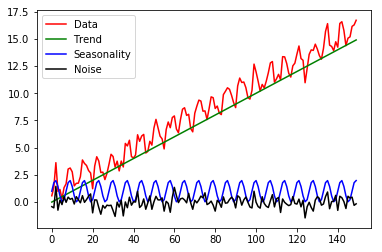

In [5]:
def plot_components(data, trend, seasonal, noise):
    plt.plot(data.asnumpy(), color="r")
    plt.plot(trend.asnumpy(), color="g")
    plt.plot(seasonal.asnumpy(), color="b")
    plt.plot(noise.asnumpy(), color="black")
    plt.legend(["Data", "Trend", "Seasonality", "Noise"]);

%matplotlib inline
plot_components(y,beta*X,mu + gamma*S,sigma*noise)

### Define the model

Just as in the chapter on `linear regression with Gluon` the linear model is defined by a single dense layer, but before the dense layer we need to add a batch normalization layer (cf the `Batch Normalization in gluon` chapter) to account for the fact that the scale of our data changes over time. 

We also initialize the parameters using a random Gaussian with variance 1.  

In [6]:
season_ctx = mx.cpu()
season_net = gluon.nn.Sequential()

with season_net.name_scope():
    season_net.add(gluon.nn.BatchNorm(axis=1, center=False, scale=True))
    season_net.add(gluon.nn.Dense(1, in_units=2))
    
season_net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=season_ctx)

square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(season_net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [7]:
print(season_net.collect_params())

sequential0_ (
  Parameter sequential0_batchnorm0_gamma (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter sequential0_batchnorm0_beta (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter sequential0_batchnorm0_running_mean (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter sequential0_batchnorm0_running_var (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter sequential0_dense0_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
  Parameter sequential0_dense0_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)


Train the model for 30 epochs

In [8]:
epochs = 30
smoothing_constant = .01
moving_loss = 0
niter = 0
loss_seq = []

for e in range(epochs):
    for i, (data, label) in enumerate(season_train_data):
        data = data.as_in_context(season_ctx)
        label = label.as_in_context(season_ctx)
        with autograd.record():
            output = season_net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
    if e % 10 ==0:
        print("Epoch %s. Moving avg of MSE: %s" % (e, est_loss)) 
        
        params = season_net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())

Epoch 0. Moving avg of MSE: 32.2507372604
Epoch 10. Moving avg of MSE: 3.66994767658
Epoch 20. Moving avg of MSE: 3.12723273528
The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
sequential0_batchnorm0_gamma 
[ 1.91860354  0.77953815]
<NDArray 2 @cpu(0)>
sequential0_batchnorm0_beta 
[ 0.  0.]
<NDArray 2 @cpu(0)>
sequential0_batchnorm0_running_mean 
[  7.53194580e+01  -2.02038828e-02]
<NDArray 2 @cpu(0)>
sequential0_batchnorm0_running_var 
[  1.12377185e+03   3.15755248e-01]
<NDArray 2 @cpu(0)>
sequential0_dense0_weight 
[[ 1.70669985  0.81172013]]
<NDArray 1x2 @cpu(0)>
sequential0_dense0_bias 
[ 8.41370487]
<NDArray 1 @cpu(0)>


Text(0,0.5,'est loss')

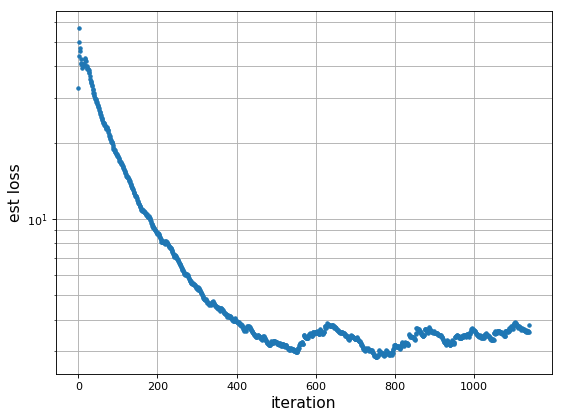

In [9]:
# plot the convergence of the estimated loss function 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
plt.semilogy(range(niter),loss_seq, '.')

# adding some additional bells and whistles to the plot
plt.grid(True,which="both")
plt.xlabel('iteration',fontsize=14)
plt.ylabel('est loss',fontsize=14)

### Generating forecasts

Now that we have estimated the model we can generate $\tau$ forecasts for $t\in[T+1, T+\tau]$ as $\hat y_t = \hat\mu + t\hat\beta$, or equivalently using the `gluon` model: `net(features[T+1:T+\tau])` 

In [10]:
fit = season_net(features[:train_length,:])
fct = season_net(features[train_length:,:])
mse = nd.mean(square_loss(fct,y[train_length:]))
print('Mean squared forecast error :%s' % mse)

Mean squared forecast error :
[ 0.13554694]
<NDArray 1 @cpu(0)>


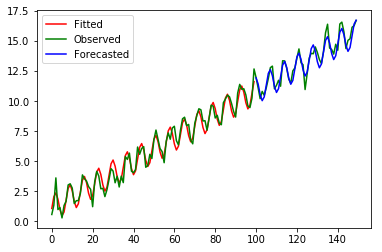

In [11]:
def plot_forecast(observed, fitted, forecasted):
    plt.plot(fitted.asnumpy(), color="r")
    plt.plot(observed.asnumpy(), color="g")
    T = len(fitted)
    plt.plot(np.arange(T, T+len(forecasted)), forecasted.asnumpy(), color="b")
    plt.legend(["Fitted", "Observed", "Forecasted"]);
plot_forecast(y,fit,fct)

# Stochastic features and dynamic models


The model we've used so far was purely deterministic and static in the sense that the value of the series at some point did not depend on its past values. In general a time series process will be dynamic, an observation at some point in time will depende on the values of previous observations. To model this kind of dependency we can include lags of the series, earlier observations aligned with the current one, for example noting $Ly_t$ the lag of $y_t$ we have $Ly_t = y_{t-1}$. $Ly_t$ is a stochastic feature, it had a random component, which implies that we cannot know its value at points in time outside of the observed sample.  


The simplest class of dynamic models is known as autoregressive, or AR, models. In the remainder of this notebook we generate data using an autoregressive model, estimate its parameters, and use it for forecasting. This section ends with a discussion of the quantification of forecast uncertainty using analytical results or numerical procedures. 

## Autoregressive models

An autoregressive model is a model in which the observation at time t, $y_t$ depends on past observations. The simplest model of this class is the autoregressive model of order 1, AR(1), meaning that $y_t$ is a function of $y_{t-1}$. This model can be written $y_t = \alpha + \beta y_{t-1} + \epsilon$.

### Estimating autoregressive models

The AR(1) model is a linear model with two mean parameters ($\alpha$, $\beta$) and a variance parameter $\sigma$. The simplest way of estimating the parameters of the AR(1) model is to use least squares, the same estimator we've used so far. 



For simplicity let's generate data from an AR(1) process recursively, with $\alpha=1$, $\beta=0.5$, $\sigma=1$.

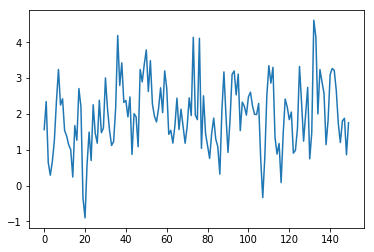

In [12]:
def gen_ar1(nobs, alpha, beta, sigma):
    y = nd.empty((nobs))
    ylag = nd.empty((nobs))
    epsilon = nd.random_normal(0, sigma, shape=(nobs)) # innovations
    y[0] = alpha + epsilon[0] #initial value
    ylag[0] = 0
    for t in range(nobs-1):
        y[t+1] = alpha + beta * y[t] + epsilon[t]
        ylag[t+1] = y[t]
    return y, ylag

y, ylag = gen_ar1(smpl_length,1,0.5,1)
plt.plot(y.asnumpy())

# We use the first 100 observations for training
ar_data = gluon.data.DataLoader(gluon.data.ArrayDataset(ylag[:train_length], y[:train_length]),
                                batch_size=batch_size, shuffle=True)

In [13]:
ar_ctx = mx.cpu()
ar_net = gluon.nn.Sequential()

with ar_net.name_scope():
    ar_net.add(gluon.nn.BatchNorm(axis=1, center=False, scale=True))
    ar_net.add(gluon.nn.Dense(1, in_units=1))
    
ar_net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ar_ctx)

square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(ar_net.collect_params(), 'sgd', {'learning_rate': 0.01})


epochs = 30
smoothing_constant = .01
moving_loss = 0
niter = 0
loss_seq = []

for e in range(epochs):
    for i, (data, label) in enumerate(ar_data):
        data = data.as_in_context(ar_ctx)
        label = label.as_in_context(ar_ctx)
        with autograd.record():
            output = ar_net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
    if e % 10 ==0:
        print("Epoch %s. Moving avg of MSE: %s" % (e, est_loss)) 
        
        params = ar_net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())


Epoch 0. Moving avg of MSE: 2.68369013701
Epoch 10. Moving avg of MSE: 0.565846990103
Epoch 20. Moving avg of MSE: 0.40341791049
The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
sequential1_batchnorm0_gamma 
[-0.33336928]
<NDArray 1 @cpu(0)>
sequential1_batchnorm0_beta 
[ 0.]
<NDArray 1 @cpu(0)>
sequential1_batchnorm0_running_mean 
[ 1.96725404]
<NDArray 1 @cpu(0)>
sequential1_batchnorm0_running_var 
[ 0.80071753]
<NDArray 1 @cpu(0)>
sequential1_dense0_weight 
[[-0.94211668]]
<NDArray 1x1 @cpu(0)>
sequential1_dense0_bias 
[ 1.92470396]
<NDArray 1 @cpu(0)>


### Forecasting with autoregressive models

Say we have a sample to $T$ observations, from $t=1$ to $t=T$, and estimates for the parameters: $\hat\alpha$, $\hat\beta$, $\hat\sigma$. We can easily forecast observation $T+1$: $\hat y_{T+1} = \hat\alpha + \hat\beta y_T$, but then we're out of observed data. What do we do now?

We can forecast $y_{T+2}$ as $\hat y_{T+2} = \hat\alpha + \hat\beta \hat y_{T+1}$, and recursively forecast $y_{T+h}$ as $\hat y_{T+h} = \hat\alpha + \hat\beta \hat y_{T+h-1}$. This is a sensible thing to do, if our model is correct and some standard assumptions are met ensuring among other things that our estimator unbiased we have: $$E(\hat y_{T+2}) = E(\hat\alpha) + E(\hat\beta) E(\hat y_{T+1}) = \alpha + \beta y_{T+1} = E(y_{T+2}).$$

So the expectation of our forecast at $T+2$ is equal to the expectation of the observation at $T+2$. Nonetheless we have added a source of uncertainty to the forecast: the right hand side lag is not a forecast and not an observation.  

In [14]:
def gen_ar1_forecasts(last_obs,npred):
    fct = nd.zeros((npred,1))
    for i in range(npred):
        if i==0:
            fct[i,:] = ar_net(last_obs)
        else:
            ypred = nd.reshape(fct[i-1],shape=(1,1))
            fct[i,:] = ar_net(ypred)
    return fct
        
last_obs = nd.reshape(y[train_length-1],shape=(1,1))    
fct = gen_ar1_forecasts(last_obs,pred_length)

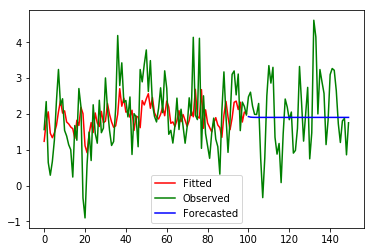

In [15]:
fit = ar_net(nd.reshape(ylag[:train_length],shape=(train_length,1)))
plot_forecast(y,fit,fct)

The mean of the AR(1) process can easily be computed: 
\begin{align*}
E(y_t) &= \alpha + \beta E(y_{t-1}) + E(\epsilon_t) \\
\mu &= \alpha + \beta \mu \\
\mu &= \frac{\alpha}{1-\beta} = \frac{1}{1-0.5}=2.
\end{align*}

Our forecast reverts to the estimated mean of the series, the dependence on past observations decays rapidly. 



### Forecast uncertainty

For most useful applications of forecasting we need to know the uncertainty around the point forecast, ideally by having the forecast take the form of a distribution instead of a single point as has been the case thus far. In this section we are going to transform our AR(1) point forecast into a distribution in two way. First we are going to derive the analytical distribution, then we are going to generate an empirical distribution by simulation.

#### Analytical forecast distribution
Our AR(1) model is linear with Gaussian disturbances. Assuming for simplicity an initial value $y_0=0$, we can write observation $y_t$ as a sum of Gaussians random variable: 
\begin{align*}
y_t &= \alpha + \beta y_{t-1} + \epsilon_t\\
&= \alpha + \beta\left(\alpha + \beta y_{t-2} + \epsilon_{t-1} \right) + \epsilon_t \\
&= ...\\
&= \frac{\alpha}{1-\beta} + \sum_{\tau=0}^t \beta^{\tau} \epsilon_{t-\tau}. 
\end{align*}
The above formula gives us the moments of the $y_t$:
\begin{align*}
E(y_t) =  \frac{\alpha}{1-\beta} = \mu\\
Var(y_t) = \sum_{\tau=0}^t \beta^{\tau} \sigma^2 \to \frac{1}{1-\beta} \sigma^2
\end{align*}
Since $y_t$ can be written as a sum of Gaussian innovations it is Gaussian, so we can write $y_t\sim\mathcal{N}(\mu,\frac{1}{1-\beta} \sigma^2)$. By extension the above argument also implies that our least squares estimates of the parameters $\alpha$ and $\beta$ are Gaussian.  


Now define the forecast error at $t+h$ based on information up to $t$ as $\hat\epsilon_{t+h|t} = y_{t+h} - \hat y_{t+h}$. Using a recursion as above, and noting $se()$ the standard deviation of the forecast error we can write:
\begin{align*}
\sigma_{p,1} = se\left(\hat\epsilon_{t+1|t} \right) &= \hat\sigma\\
\sigma_{p,2} = se\left(\hat\epsilon_{t+2|t} \right) &= \hat\sigma\sqrt{(1+\hat\beta)}\\
...&=...\\ 
\sigma_{p,h} = se\left(\hat\epsilon_{t+h|t} \right) &= \hat\sigma\sqrt{(1+\sum_{\tau=1}^{h-1}\hat\beta^\tau)}
\end{align*}

And so a 90% prediction interval for forecast at time $h$ is $\hat y_{t+h}\pm 1.65 \sigma_{ph}$. 

In [16]:
# estimate sigma_{ph}
residuals = y[:train_length]-fit
sigma_hat = np.std(residuals.asnumpy())
dense_weight = params["sequential1_dense0_weight"].data().asnumpy()
batchnorm_var = params["sequential1_batchnorm0_gamma"].data().asnumpy()
beta_hat = dense_weight*batchnorm_var

sigph = sigma_hat * np.sqrt(np.cumsum([pow(beta_hat,2*h) for h in range(pred_length)]))
sigph = np.reshape(sigph,(pred_length,1))
pred_interval = np.concatenate((fct.asnumpy() - 1.65*sigph,
                                fct.asnumpy() + 1.65*sigph),axis=1)

In [17]:
def plot_forecast_interval(observed, fitted, forecasted, interval):
    plt.plot(fitted.asnumpy(), color="r")
    plt.plot(observed.asnumpy(), color="g")
    T = len(fitted)
    plt.plot(np.arange(T, T+len(forecasted)), forecasted.asnumpy(), color="b")
    plt.fill_between(np.arange(T, T+len(forecasted)), interval[0,:], interval[1,:])
    plt.legend(["Fitted", "Observed", "Forecasted"]);

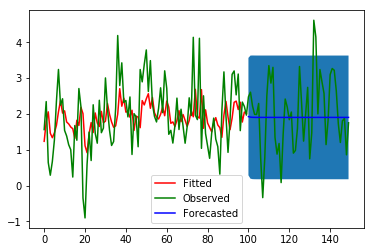

In [18]:
plot_forecast_interval(y,fit,fct,np.transpose(pred_interval))

#### Numerical forecast distribution

In the previous section we derived an analytical distribution for the forecast. This was possible because the model is quite simple and we have made strong assumptions on the distribution of the data. This approach is often not feasible, instead we can resort to numerical simulation to estimate an empirical distribution for the forecast. 

If we assume that the model we have estimated is the _correct_ model, it is reasonable to assume that our out of sample prediction errors will have the same statistical properties as our in sample prediction errors. 





In [19]:
def gen_ar1_prediction_interval(last_obs,npred,niter,resid):
    fct = nd.zeros((npred,niter))
    for i in range(niter):
        for j in range(npred):
            # resampling the residuals
            sample_indices = np.random.randint(resid.shape[0],size = npred)
            resamp = resid.asnumpy()[sample_indices,:]
            resamp = nd.array(resamp)
            if j==0:
                fct[j,i] = ar_net(last_obs) + resamp[j,:]
            else:
                ypred = nd.reshape(fct[j-1,i],shape=(1,1)) 
                fct[j,i] = ar_net(ypred) + resamp[j,:]
    # computing the prediction interval
    pred_interval = np.percentile(fct.asnumpy(),q=[5,95],axis=1)
    return pred_interval

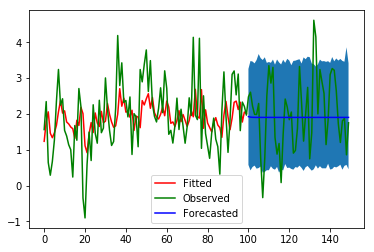

In [20]:
# compute the residuals of the fitted model
resid = nd.reshape(y[:train_length], (train_length,1)) - fit
pred_interval = gen_ar1_prediction_interval(last_obs,pred_length,1000,resid)
plot_forecast_interval(y,fit,fct,pred_interval)